In [1]:
import re
import nltk
from nltk.corpus import stopwords


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dense, Input, Flatten
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 2000000
EMBEDDING_DIM = 100

In [3]:
df = pd.read_csv("Reviews.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
data = df.sample(n=20000)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 523074 to 524852
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      20000 non-null  int64 
 1   ProductId               20000 non-null  object
 2   UserId                  20000 non-null  object
 3   ProfileName             20000 non-null  object
 4   HelpfulnessNumerator    20000 non-null  int64 
 5   HelpfulnessDenominator  20000 non-null  int64 
 6   Score                   20000 non-null  int64 
 7   Time                    20000 non-null  int64 
 8   Summary                 19998 non-null  object
 9   Text                    20000 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


In [7]:
data.reset_index(inplace=True, drop=True)

In [8]:
wl = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

In [9]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z\s]','',text)
    stop = stopwords.words('english')
    text = [ps.stem(wl.lemmatize(word)) for word in text.split() if word not in stop]
    return text
    

In [10]:
processed_data = data['Text'].map(preprocess)

In [11]:
tokenizer = Tokenizer()#num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(processed_data)
sequences = tokenizer.texts_to_sequences(processed_data)

word_index = tokenizer.word_index
len(word_index)

29021

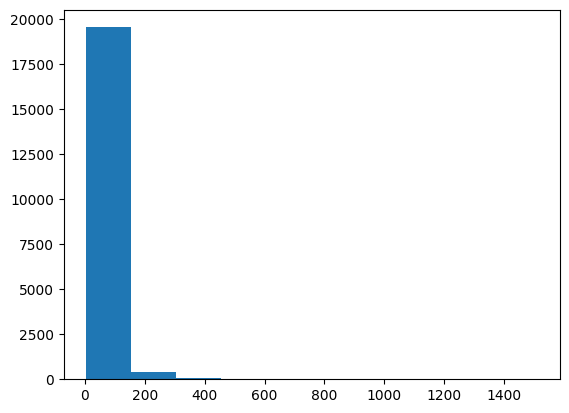

In [12]:
dct = []
for i in sequences:
    dct.append(len(i))
        
plt.hist(dct)
plt.show()

In [13]:
# labels = np.asarray(data['Score']).astype(np.float32)

In [14]:
final = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)
labels = pd.get_dummies(data['Score'],dtype='int')
final.shape, labels.shape

# features = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)

# features.shape, labels.shape

((20000, 100), (20000, 5))

In [15]:
labels.head()

,1,2,3,4,5
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,1,0


In [16]:
x_train, x_test, y_train, y_test = train_test_split(final, labels, test_size = 0.2, random_state = 20)
x_test, x_val, y_test, y_val = train_test_split( final, labels, test_size=0.50, random_state=4)
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

# x_train, x_test, y_train, y_test = train_test_split( features, labels, test_size=0.20, random_state=42)
# x_test, x_val, y_test, y_val = train_test_split( features, labels, test_size=0.50, random_state=4)
# x_train.shape, y_train.shape

((16000, 100), (10000, 100), (10000, 100), (16000, 5), (10000, 5), (10000, 5))

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

In [18]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(128,fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)   
l_merge = Concatenate()(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
# l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             2902200   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 98, 128)              38528     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 97, 128)              51328     ['embedding[0][0]']           
                                                                                              

In [19]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=25, batch_size=150)

Epoch 1/25
107/107 [==============================] - 78s 626ms/step - loss: 0.3683 - acc: 0.6352 - val_loss: 0.3117 - val_acc: 0.6470
Epoch 2/25
107/107 [==============================] - 65s 606ms/step - loss: 0.2919 - acc: 0.6710 - val_loss: 0.2570 - val_acc: 0.7043
Epoch 3/25
107/107 [==============================] - 80s 752ms/step - loss: 0.2415 - acc: 0.7174 - val_loss: 0.2216 - val_acc: 0.7513
Epoch 4/25
107/107 [==============================] - 91s 857ms/step - loss: 0.1938 - acc: 0.7791 - val_loss: 0.1890 - val_acc: 0.7911
Epoch 5/25
107/107 [==============================] - 90s 839ms/step - loss: 0.1467 - acc: 0.8371 - val_loss: 0.1676 - val_acc: 0.8401
Epoch 6/25
107/107 [==============================] - 92s 866ms/step - loss: 0.1073 - acc: 0.8865 - val_loss: 0.1744 - val_acc: 0.8558
Epoch 7/25
107/107 [==============================] - 91s 854ms/step - loss: 0.0775 - acc: 0.9214 - val_loss: 0.1690 - val_acc: 0.8760
Epoch 8/25
107/107 [==============================] - 9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


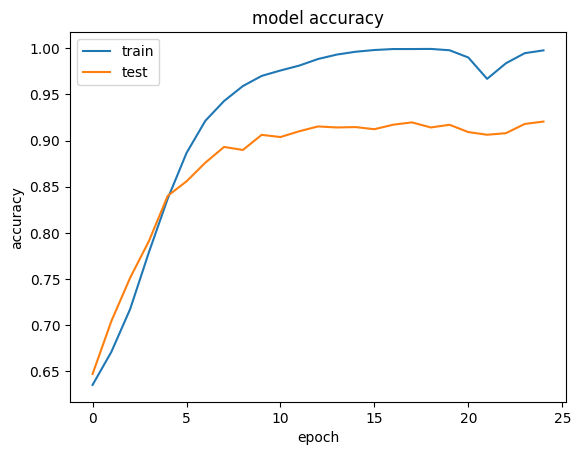

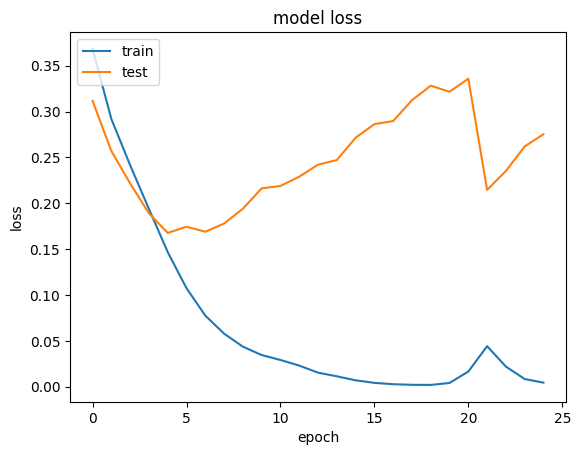

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
y_pred = model.predict(x_test, verbose=1)

313/313 [==============================] - 4s 13ms/step


In [22]:
def fx(array):
    return np.argmax(array)

temp = np.array(y_test)
st_pred = y_pred.tolist()
st_temp = temp.tolist()

arr = np.array(list(map(fx,st_temp)))
ans = np.array(list(map(fx,st_pred)))
f1 = f1_score(arr,ans, average='micro')
r1 = recall_score(arr, ans, average='micro')
p1 = precision_score(arr,ans, average='micro')
acc = accuracy_score(arr,ans)
print('f1',f1)
print('r1',r1)
print('p1',p1)
print('acc', acc)

f1 0.9206
r1 0.9206
p1 0.9206
acc 0.9206


In [ ]:
cm = confusion_matrix(arr, ans)
cm